In [1]:
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import layer_utils, np_utils
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet50 import preprocess_input
from keras import Model
from keras import initializers
from keras.callbacks import LearningRateScheduler
import resnet
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [2]:
image_width = 224
image_height = 224

# Change the batchsize according to your system RAM
train_batchsize = 16
val_batchsize = 16
train_dir = "D:/retinal_data_set_visioncare/TrainValidationData/augmented_train_data_224"
validation_dir = "D:/retinal_data_set_visioncare/TrainValidationData/validation"
test_dir = "D:/retinal_data_set_visioncare/newTrainValidationTestData/new_test"

model_check_point_loc = 'D:/retinal_data_set_visioncare/models/resnet50/resnet_dr.h5'

resnet_base = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))
#resnet_base = resnet.ResNet101(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [3]:
# Freeze the layers except the last 2 layers
for layer in resnet_base.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in resnet_base.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x00000297D54E1860> False
<keras.layers.convolutional.ZeroPadding2D object at 0x00000297D54E1C50> False
<keras.layers.convolutional.Conv2D object at 0x00000297D54E1AC8> False
<keras.layers.normalization.BatchNormalization object at 0x00000297D54E1A58> False
<keras.layers.core.Activation object at 0x00000297D55147F0> False
<keras.layers.pooling.MaxPooling2D object at 0x00000297D557E470> False
<keras.layers.convolutional.Conv2D object at 0x00000297D54FEB70> False
<keras.layers.normalization.BatchNormalization object at 0x00000297DACEB160> False
<keras.layers.core.Activation object at 0x00000297DACBFC88> False
<keras.layers.convolutional.Conv2D object at 0x00000297DAD12F60> False
<keras.layers.normalization.BatchNormalization object at 0x00000297DAD06DD8> False
<keras.layers.core.Activation object at 0x00000297DAD65FD0> False
<keras.layers.convolutional.Conv2D object at 0x00000297DC5035F8> False
<keras.layers.convolutional.Conv2D object at 0x000

In [4]:
resnet_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [11]:
# Create the model
# add a global spatial average pooling layer 55 , 55 , 64
x = resnet_base.get_layer('activation_39').output
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.2, name='global_avg_dropout')(x)
# add a fully-connected layer
x = Dense(100, kernel_initializer=initializers.he_normal(seed=None), use_bias=False, kernel_regularizer=regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5, name='fc1_dropout')(x)
# and a fully connected output/classification layer
#x = Dense(5, kernel_initializer=initializers.he_normal(seed=None))(x)
x = Dense(5, kernel_regularizer=regularizers.l2(0.001), use_bias=False)(x)
x = BatchNormalization()(x)
predictions = Activation('softmax')(x)
# create the full network so we can train on it
model = Model(inputs=resnet_base.input, outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [6]:
# model = Sequential() # our defined model functions in some sort of sequence, we use the Sequential class to initialize our model before adding the layers

# # Here's how you add layers to your model
# # Conv1 32 32 (3) => 30 30 (32)
# model.add(Conv2D(32, (3, 3), input_shape=X_shape[1:])) # in layer 1 you need to specify input shape this is not needed in subsequent layers
# model.add(Activation('relu'))
# # Conv2 30 30 (32) => 28 28 (32)
# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# # Pool1 28 28 (32) => 14 14 (32)
# model.add(MaxPooling2D(pool_size=(2, 2))) # the CONV CONV POOL structure is popularized in during ImageNet 2014
# model.add(Dropout(0.25)) # this thing called dropout is used to prevent overfitting

# # Conv3 14 14 (32) => 12 12 (64)
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# # Conv4 12 12 (64) => 6 6 (64)
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# # Pool2 6 6 (64) => 3 3 (64)
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# # FC layers 3 3 (64) => 576
# model.add(Flatten()) # to turn input into a 1 dimensional array
# # Dense1 576 => 256
# model.add(Dense(256))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# # Dense2 256 => 10
# model.add(Dense(num_classes))
# model.add(Activation('softmax')) #

In [12]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_width, image_height),
        batch_size=train_batchsize,
        shuffle=True,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(image_width, image_height),
        batch_size=train_batchsize,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(image_width, image_height),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 5000 images belonging to 5 classes.
Found 281 images belonging to 5 classes.
Found 142 images belonging to 5 classes.


In [13]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

In [14]:
model_checkpoint = ModelCheckpoint(model_check_point_loc, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

In [9]:
#annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [10]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size,
      epochs=100,
      callbacks=[model_checkpoint],
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//validation_generator.batch_size,
      verbose=1)

Epoch 1/100
312/312 [==============================] - 202s 649ms/step - loss: 2.1253 - acc: 0.2754 - val_loss: 1.6429 - val_acc: 0.5956
Epoch 2/100
312/312 [==============================] - 198s 634ms/step - loss: 1.8084 - acc: 0.3790 - val_loss: 1.5709 - val_acc: 0.5735
Epoch 3/100
 40/312 [==>...........................] - ETA: 2:41 - loss: 1.7373 - acc: 0.3984

KeyboardInterrupt: 

In [11]:
train_generator.samples

5000

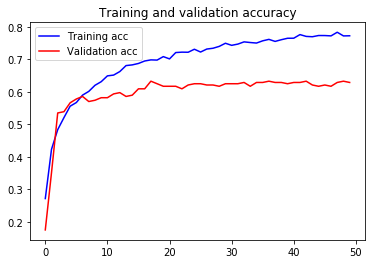

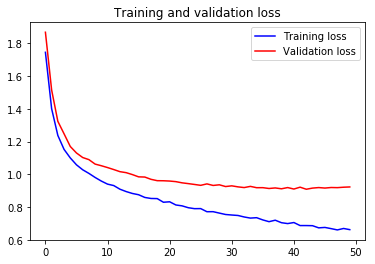

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [13]:
# Returns a compiled model identical to the previous one
loaded_model = load_model(model_check_point_loc)

In [14]:
#Confution Matrix and Classification Report
Y_pred = loaded_model.predict_generator(validation_generator, validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['non-dr', 'mild-npdr', 'moderate-npdr', 'severe-npdr', 'pdr']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[139   8   3   0   0]
 [ 30   4   3   0   0]
 [ 34   1  10   0   0]
 [  5   1   5   9   0]
 [ 10   1  15   1   2]]
Classification Report
               precision    recall  f1-score   support

       non-dr       0.64      0.93      0.76       150
    mild-npdr       0.27      0.11      0.15        37
moderate-npdr       0.28      0.22      0.25        45
  severe-npdr       0.90      0.45      0.60        20
          pdr       1.00      0.07      0.13        29

  avg / total       0.59      0.58      0.52       281



In [25]:
validation_generator.samples

126

In [6]:
#Confution Matrix and Classification Report for testset
Y_pred_for_test = loaded_model.predict_generator(test_generator, test_generator.samples // test_generator.batch_size)
Y_pred_for_test = np.argmax(Y_pred_for_test, axis=1)
print('Confusion Matrix for testset')
print(confusion_matrix(test_generator.classes, Y_pred_for_test))
print('Classification Report')
target_names = ['non-dr', 'mild-npdr', 'moderate-npdr', 'severe-npdr', 'pdr']
print(classification_report(test_generator.classes, Y_pred_for_test, target_names=target_names))

Confusion Matrix for testset
[[169  22   8   1   0]
 [ 25 167   3   5   0]
 [ 13  13 153  20   1]
 [  5   9  10 173   3]
 [  0   0   0   1 199]]
Classification Report
               precision    recall  f1-score   support

       non-dr       0.80      0.84      0.82       200
    mild-npdr       0.79      0.83      0.81       200
moderate-npdr       0.88      0.77      0.82       200
  severe-npdr       0.86      0.86      0.86       200
          pdr       0.98      0.99      0.99       200

  avg / total       0.86      0.86      0.86      1000



In [33]:
# generate roc curve
n_classes = 5

# Plot linewidth.
lw = 2

#convert original class labels to the one-hot-encoding
y_test = np_utils.to_categorical(test_generator.classes, 5)

Y_test_pred = loaded_model.predict_generator(test_generator, test_generator.samples // test_generator.batch_size)
Y_test_predicted = np.argmax(Y_test_pred, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], Y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [34]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), Y_test_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [36]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

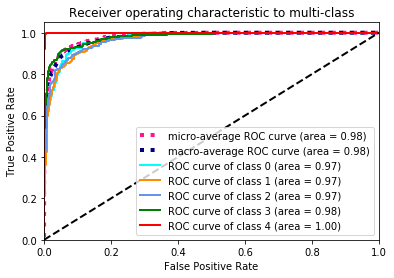

In [38]:
# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

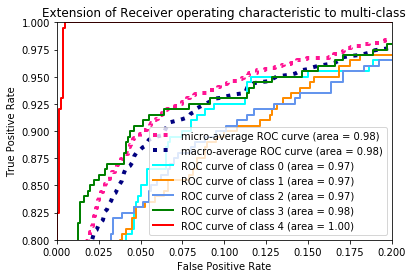

In [39]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()